## Postfire Restoration Tool

We are developing this tool using a Jupyter notebook framework. Jupyter has become an extremely important platform for creating reproducible and interactive workflows for scientific computations, and is a good fit for our project since we are in the continual process of refining our model of postfire restoration. The Python backend will allow for integration with a variety of platforms.

Our logic at present is to develop a potential regeneration score that applies across a species community, after computing scores for each species singly.

### Step 0 - Preliminaries

#### Read in species table

The first step is to read in a table of the species-by-species trait characteristics.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
traits1 = pd.read_csv("./datasets/SpeciesTableSummary1.csv")
traits1

,Species,PreferredAspect,FunctionalGroup,PreferredTopography,GrowthRateScore,RecruitmentScore,FireCountThreshold,FRITooFrequent,FireSeverityLowMod,FireSeverityHigh,Drought1stYr,Drought2ndYr,NonNatives
0,Arctostaphylos glauca,variety,seeder,not steep,35,35,1,-80,80,80,50,20,50
1,Acmispon glaber,variety,seeder,not steep,80,50,3,-80,80,50,80,20,50
2,Ceanothus vestitus,N,seeder,not steep,80,50,1,-80,50,80,80,20,20
3,Ceanothus cuneatus,variety,seeder,not steep,75,50,1,-80,50,80,80,20,50
4,Ceanothus crassifolius,S,seeder,not steep,20,50,5,-80,50,80,50,20,50
5,Adenostoma fasciculatum,S,facultative seeder,not steep,20,50,2,-80,75,35,75,20,80
6,Salvia mellifera,variety,facultative seeder,not steep,50,50,2,-50,80,50,50,20,75
7,Eriodictyon crassifolium,S,facultative seeder,not steep,75,50,2,-50,75,20,80,20,80
8,Eriogonum fasciculatum,S,facultative seeder,not steep,50,35,2,-75,75,50,80,20,35
9,Artemisia californica,N,facultative seeder,steep slopes,80,35,1,-80,50,20,75,20,35


#### Species inputs

One of our inputs will be lists of species in each ecological unit grouping, with approximate cover rankings. We will use this coding for the cover rankings:

|Cover interval|Cover code|
--------------------|--------------------
|60%-100%|3|
|30%-60%|2|
|0-30%|1|

Coding these breaks into Python:

In [4]:
coverbreaks = [.15, .45, .8]

Here's a sample species list:

In [5]:
specieslist1 = [['Adenostoma fasciculatum', 3], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 1]]


### Determine a potential regeneration score for a single species based on environmental conditions

In [6]:
# Species Step 1 weighting
# take species name, the aspect of the terrain, whether steep or not, and number of fires,
# and output a score for potential regeneration. 
def speciesstep1(specname, aspect, topography, firecount):
    specrow = traits1.loc[traits1['Species']==specname]
    prefaspect = specrow['PreferredAspect'].iloc[0]
    preftopo = specrow['PreferredTopography'].iloc[0]
    maxfire = specrow['FireCountThreshold'].iloc[0]
    functionalgroup = specrow['FunctionalGroup'].iloc[0]
    # let's start our scoring based on the functional group of the species
    if(functionalgroup == 'sprouters'):
        startval = 80
    else: # it's a seeder or facultative seeder
        startval = 50
    if(prefaspect == aspect):
        startval += 20
    if(preftopo == topography):
        startval += 20
    if(firecount >= maxfire):
        startval -= 40
    
    return startval
    

#### A couple of example queries  

Here we are looking at the potential regeneration for a single species under a particular aspect, slope, and number of previous fires. The idea is that this query will be made on a pixel-by-pixel basis.

In [7]:
# What is the potential regeneration for Adenostema fasciculatum on north-facing steep slopes with only 1 fire in
# the past 40 years?
speciesstep1('Adenostoma fasciculatum', 'N', 'steep slopes', 1) 

50

In [8]:
# What is the potential regeneration for Prunus ilicifolia on not-so-steep south-facing slopes with 3 fires in
# the past 40 years?
speciesstep1('Prunus ilicifolia', 'S', 'not steep', 3)

10

### Determine a potential regeneration score for a single species based on inherent species traits

We combine the attributes of growth rate and recruitment rate here. 

In [9]:
# Species Step 1 weighting by growth and recruitment rate

def speciessteptraits1(specname):
    specrow = traits1.loc[traits1['Species']==specname]
    growthrate = specrow['GrowthRateScore'].iloc[0]
    recruit = specrow['RecruitmentScore'].iloc[0]
    startval = (growthrate + recruit)/2
    
    return startval

### Combine the scores from each species using a weighted average in the species groups

I am averaging the score from the growth and recruitment rate together with the score from the environmental conditions.

In [10]:
def specgroupstep1(specgroup, aspect, topography, firecount):
    numspecies = len(specgroup)
    speclist = [s[0] for s in specgroup]
    speclistscore = [speciesstep1(spec, aspect, topography, firecount) for spec in speclist]
    speclisttrait = [speciessteptraits1(spec) for spec in speclist]
    coverlevels = [coverbreaks[s[1]-1] for s in specgroup]
    #speclistscore = [speciesstep1(speclist[0], aspect, topography, firecount)]
    covercross = map(lambda x,y,z:y*(x+z)/2,speclistscore,coverlevels, speclisttrait)
    #specgroupscore = sum(covercross)/numspecies 
    specgroupscore = sum(covercross) # maybe we shouldn't divide here
    return specgroupscore

#### A couple of example conditions with this species list. (specieslist1)

|Species|Cover percentage|
|-------|------------|
|Adenostema fasciculatum|60-100%|
|Ceanothus cuneatus|0-30%|
|Salvia mellifera|0-30%|

First, with south-facing, not steep slopes and a count of 3 fires in the past 40 years:

In [11]:
specgroupstep1(specieslist1, 'S', 'not steep', 3)

46.9375

Next, with south-facing steep slopes and 1 fire in past 40 years.

In [12]:
specgroupstep1(specieslist1, 'S', 'steep slopes', 1)

54.9375

## Step 1 - Potential regeneration

I will show the rasters we are working with below.

### Count of fires in the 40 years prior to 2002

In [13]:
firecount = rasterio.open("datasets/firecount1962_2001CFmask.tif")

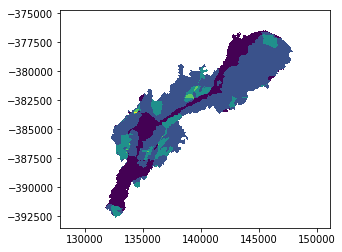

In [14]:
rasterio.plot.show(firecount,1)

### Geomorphons and aspect

Geomorphons are a way of describing landscape physiography using a pattern identification algorithm. There are
10 geomorphon types in total, namely:

-  flats
-  summits
-  ridges
-  shoulders
-  spurs
-  slopes
-  hollows
-  footslopes
-  valleys
-  depressions

In the layer displayed below I have lumped hollows, spurs, and slopes together and separated this grouping by north and south aspect. The class coding is as follows:

|Class number|Geomorphon Type|
|------------|---------------|
|1|Flats|
|2|Summits|
|3|Ridges|
|4|Shoulders|
|8|Footslopes|
|9|Valleys|
|10|Depressions|
|11|North-facing slopes, spurs, and hollows|
|12|South-facing slopes, spurs, and hollows|

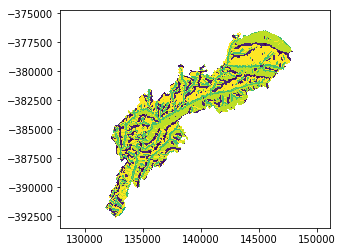

In [15]:
nsgeomorphon = rasterio.open("datasets/nsgeomorphonCFmask.tif")
rasterio.plot.show(nsgeomorphon,1)

### Slope

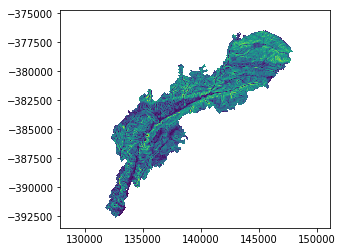

In [16]:
slope = rasterio.open("datasets/slopeCFmask.tif")
rasterio.plot.show(slope,1)

### Making up some species lists

These aren't meant to be real. I'm coming up with assignments of species to the geomorphon-based land classes.

In [17]:
spececodict = {1: [['Prunus ilicifolia', 2], ['Artemisia californica', 2], ['Eriogonum fasciculatum', 2]],
               2: [['Ceanothus leucodermis', 2], ['Ceanothus cuneatus', 2], ['Eriodictyon crassifolium', 2]],
               3: [['Adenostoma fasciculatum', 3], ['Ceanothus cuneatus', 1], ['Quercus berberidifolia', 1]],
               4: [['Adenostoma fasciculatum', 3], ['Ceanothus leucodermis', 1], ['Acmispon glaber', 1]],
               8: [['Salvia mellifera', 3], ['Hesperoyucca whipplei', 1]],
               9: [['Artemisia californica', 3], ['Malacothamnus fasciculatus', 1], ['Salvia mellifera', 1]],
               10: [['Artemisia californica', 3], ['Ceanothus cuneatus', 1], ['Ceanothus crassifolius', 1]],
               11: [['Eriodictyon crassifolium', 3], ['Ceanothus cuneatus', 1], ['Salvia mellifera', 1]],
               12: [['Arctostaphylos glauca', 2], ['Ceanothus cuneatus', 2], ['Salvia mellifera', 2]]}

In [18]:
spececodict[2]

[['Ceanothus leucodermis', 2],
 ['Ceanothus cuneatus', 2],
 ['Eriodictyon crassifolium', 2]]

We now want a function to wrap the values in the rasters (which are integer, integer, and float) and return the species group score. This should be robust to all the values in the rasters, including what it uses as NAs.

This depends on the raster: for firecount and nsgeomorphon, it's 255.0, for slope it's nan.

In [34]:
def rastervalStep1a(specname, nsgeomorphon, firecount, slope):
    #if ((nsgeomorphon == 255 ) or (firecount == 255) or np.isnan(slope)):
    #if ((nsgeomorphon == 255 ) or (firecount == 255) or (slope > 10000)):
    if np.any([nsgeomorphon == 255, firecount == 255, np.isnan(slope)]):    
       return np.nan
    else:
        if(nsgeomorphon == 11):
            nsgeomorphon2 = 'N'
        elif(nsgeomorphon == 12):
            nsgeomorphon2 = 'S'
        else:
            nsgeomorphon2 = 'variety'
        
        if (slope > 25):
            slope2 = 'steep slopes'
        else:
            slope2 = 'not steep'
    # print(nsgeomorphon2, slope2, firecount)
        specval = speciesstep1(specname, nsgeomorphon2, slope2, firecount)
        return specval

    

In [35]:
rastervalStep1a('Adenostoma fasciculatum', 11, 3, 7)

30

In [50]:
# calculate the raster map
def rastervalStep1b(specname, nsgeomorphonrast, firecountrast, sloperast):
    nsgeomorphonrast2 = nsgeomorphon.read()
    firecountrast2 = firecountrast.read()
    sloperast2 = sloperast.read()
    vfunc = np.vectorize(rastervalStep1a) # this is key.
    # outrast = rastervalStep1a(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    outrast = vfunc(specname, nsgeomorphonrast2, firecountrast2, sloperast2)
    return outrast
    

In [23]:
firecount

<open DatasetReader name='datasets/firecount1962_2001CFmask.tif' mode='r'>

In [24]:
nsgeomorphon

<open DatasetReader name='datasets/nsgeomorphonCFmask.tif' mode='r'>

In [25]:
slope

<open DatasetReader name='datasets/slopeCFmask.tif' mode='r'>

In [47]:
chamiserast = rastervalStep1b('Adenostoma fasciculatum', nsgeomorphon, firecount, slope)

In [48]:
chamiserast

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [49]:
np.nanmean(chamiserast)

66.88918900039583

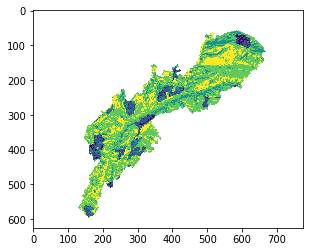

In [51]:
rasterio.plot.show(chamiserast,1)

It looks like we lost our georeferencing here but that can be fixed.

In [39]:
n1

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [40]:
s1 = slope.read()

In [41]:
s1

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [45]:
np.nanmean(f1)

209.93778167741937